# CIFAR-10 데이터셋을 이용한 합성곱 신경망 구성 

## 필요한 모듈 추가

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## 디바이스 설정

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## 데이터 로드

- 이미지 전처리 설정

In [3]:
pre_processing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

- CIFAR-10 데이터셋 로드
    - 훈령용 데이터를 **train_data=85%**, **valid_data=15%**로 split

In [4]:
data_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=pre_processing)
test_data = datasets.CIFAR10(root='../data', train=False, download=True, transform=pre_processing)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_len = int(len(data_set) * 0.85)
valid_len = int(len(data_set) * 0.15)
train_data, valid_data = torch.utils.data.random_split(data_set, [train_len, valid_len])

In [6]:
len(train_data), len(valid_data), len(test_data)

(42500, 7500, 10000)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

- 이미지 시각화

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    #img = np.transpose(npimg, (1, 2, 0))
    img = img.transpose(0, 1)
    img = img.transpose(1, 2)
    return img

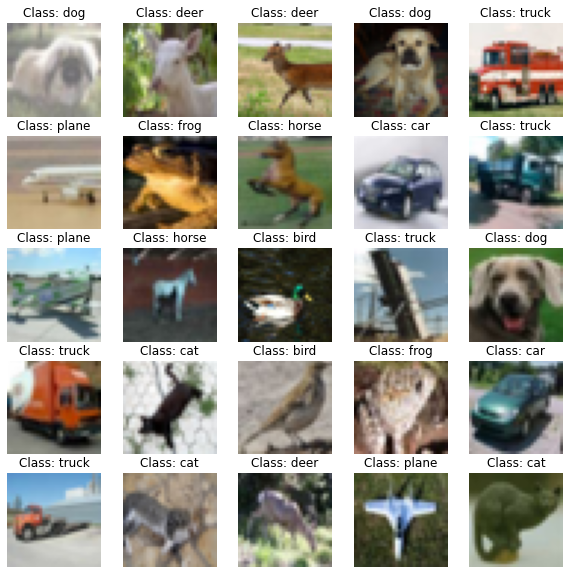

In [13]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[sample_idx]
    plt.subplot(cols, rows, i)
    img = imshow(image)
    plt.imshow(img)
    plt.title(f'Class: {classes[label]}')
    plt.axis("off")
plt.show()

## 합성곱 신경망 정의

### 출력 크기 계산기
- padding이 1 or 'same' 일 경우 출력의 크기는 입력의 크기와 동일하다.
- pooling 층이 있을 경우, 입력의 크기를 pooling의 크기로 나눠주면 출력의 크기이다.

In [14]:
Hin = 14
Win = 14
kernel_size = (5, 5)

def param_calculatpr(Hin, Win, kernel_size, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):    
    Hout = ((Hin + (2 * padding[0]) - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1
    Wout = ((Win + (2 * padding[1]) - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1

    return (Hout, Wout)

param_calculatpr(Hin, Win, kernel_size)


(10.0, 10.0)

In [15]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D 합성곱층 정의
        conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, dilation=1)
        conv2 = nn.Conv2d(6, 16, 5)
        # 풀링층 정의
        pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # flatten layer 정의
        flatten = nn.Flatten()
        
        self.conv_module = nn.Sequential(
            conv1, nn.ReLU(),
            pool,
            conv2, nn.ReLU(),
            pool, flatten
        )
        
        # 완전 연결층 정의(fully connected layer)
        fc1 = nn.Linear(5*5*16, 120)
        fc2 = nn.Linear(120, 84)
        fc3 = nn.Linear(84, 10)
        # Dropout 층 정의
        dropout = nn.Dropout2d(0.5)

        self.fc_module = nn.Sequential(
            fc1, nn.ReLU(),
            fc2, nn.ReLU(),
            fc3, 
        )

    def forward(self, x):
        x = self.conv_module(x)
        #x = x.view(-1, 16 * 5 * 5)
        x = self.fc_module(x)
        output = F.softmax(x, dim=1)
        return output

In [16]:
my_model = CNNClassifier().to(device)

## 손실함수와 최적화기 정의

In [17]:
import torch.optim as optim

In [18]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()  # 손실함수 설정
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)  # 최적화 설정

In [19]:
num_epochs = 5

In [20]:
def get_accuracy(y, label):
    y_idx = torch.argmax(y, dim=1)
    result = y_idx - label

    num_correct = 0
    for i in range(len(result)):
        if result[i] == 0:
            num_correct += 1

    return num_correct/y.shape[0]

In [24]:
import time

def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(train_loader)
    train_loss_list, train_acc_list = [], []

    start_time = time.time()
    for batch, (x, y) in enumerate(dataloader):
        print(f'image: {len(x)}')
        print(f'labels: {len(y)}')
        model.train()
        # x: 입력, y: 정답(레이블)을 받아온 후 device에 올려줌
        x, y = x.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(x)
        loss = loss_fn(pred, y)  # 손실함수 계산

        # 역전파
        optimizer.zero_grad() # 학습 수행 전 미분값을 0으로 초기화(학습전 반드시 처리 필요)
        loss.backward()       # 가중치와 편향에 대한 기울기 계산
        optimizer.step()      # 가중치와 편향 업데이트

        # 학습 정확도 및 손실함수 값 기록
        train_acc = get_accuracy(pred, y)  # 정확도 계산

        train_loss_list.append(loss.item())
        train_acc_list.append(train_acc)

        if (batch+1) % num_batches == 0:
            print(f'step: {batch+1}/{num_batches} | {time.time() - start_time:.2f} s/step | ', end='')
            print(f'train loss: {np.mean(train_loss_list):.4f} | train acc: {np.mean(train_acc_list):.4f} | ', end='')

In [25]:
def valid(dataloader, model):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        val_loss_list, val_acc_list = [], []

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            correct = model(x)
            val_loss = loss_fn(correct, y)

            val_acc = get_accuracy(correct, y)

            val_loss_list.append(val_loss.item())
            val_acc_list.append(val_acc)
        print(f'valid loss: {np.mean(val_loss_list):.4f} | valid acc: {np.mean(val_acc_list):.4f}')

In [26]:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    train(train_loader, my_model, loss_fn, optimizer)
    valid(valid_loader, my_model)
print("Done!")   

Epoch: 1/5
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
image: 128
labels: 128
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10fd14790>
Traceback (most recent call last):
  File "/Users/churry/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/churry/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  Fil

KeyboardInterrupt: 

## 시험용 데이터로 신경망 평가

In [25]:
def test_1(dataloader, model):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        test_loss_list, test_acc_list = [], []

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            correct = model(x)
            test_loss = loss_fn(correct, y)

            test_acc = get_accuracy(correct, y)

            test_loss_list.append(test_loss.item())
            test_acc_list.append(test_acc)
        print(f'Test loss: {np.mean(test_loss_list):.4f} | Test acc: {np.mean(test_acc_list):.4f}')

In [26]:
test_1(test_loader, my_model)

Test loss: 1.9735 | Test acc: 0.4832


In [27]:
def test_2(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [28]:
test_2(test_loader, my_model)

Test Error: 
 Accuracy: 48.4%, Avg loss: 0.015591


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


- 테스트 이미지 확인

In [30]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

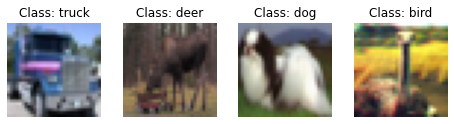

In [31]:
plt.figure(figsize=(10, 10))
index = 0
for i in range(4):
    img = images[i]
    img = img / 2 + 0.5
    npimg = np.array(img)
    trans_img = np.transpose(npimg, (1, 2, 0))
    index += 1
    plt.subplot(5, 5, index)
    plt.imshow(trans_img)
    plt.title("Class: {}".format(classes[labels[i]]))
    plt.axis("off")
plt.show()

In [32]:
images, labels = images.to(device), labels.to(device)
images.shape

torch.Size([128, 3, 32, 32])

In [33]:
outputs = my_model(images)
outputs.shape

torch.Size([128, 10])

In [34]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(4)))
print('Answer: ', ' '.join(classes[labels[j]] for j in range(4)))

Predicted:  car horse dog dog
Answer:  truck deer dog bird


- 각 클래스 별로 학습한 정도 확인

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 56 %
Accuracy of  bird : 29 %
Accuracy of   cat : 48 %
Accuracy of  deer : 35 %
Accuracy of   dog : 48 %
Accuracy of  frog : 45 %
Accuracy of horse : 53 %
Accuracy of  ship : 45 %
Accuracy of truck : 54 %


## 학습한 모델 저장

In [50]:
PATH_1 = './models/cifar_net_model.pth'
# 전체 모델 저장
torch.save(my_model, PATH_1)
# 학습한 모델의 파라미터 저장
PATH_2 = './models/cifar_net_parameters.pth'
torch.save(my_model.state_dict(), PATH_2)

## 학습한 모델 불러오기

In [56]:
#model = CNNClassifier().to(device)
load_model = torch.load(PATH_1).to(device)
load_model

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_module): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [54]:
load_parameters = torch.load(PATH_2)

In [55]:
load_model.load_state_dict(load_parameters)

<All keys matched successfully>

## 새로운 이미지로 분류 예측

In [92]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

Saving airplane.jpg to airplane (2).jpg
Saving dog2.jpg to dog2 (2).jpg
Saving frog.jpg to frog (2).jpg


In [58]:
import glob

images = glob.glob('./my_images/*.jpg')
images

['./my_images/dog.jpg', './my_images/airplane.jpg', './my_images/frog.jpg']

In [60]:
import PIL
from torchvision import transforms

In [62]:
pre_processing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

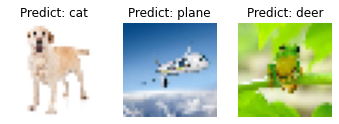

In [66]:
plt.figure(figsize=(10, 10))
index = 0
for path in images:
    #path = '/content/' + _file
    img = PIL.Image.open(path)
    img = pre_processing(img)

    image = torch.reshape(img, (1, 3, 32, 32))
    image = image.to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

    img = img / 2 + 0.5
    npimg = np.array(img)
    trans_img = np.transpose(npimg, (1, 2, 0))
    index += 1

    plt.subplot(5, 5, index)
    plt.imshow(trans_img)
    plt.title("Predict: {}".format(classes[predicted[0]]))
    plt.axis("off")
plt.savefig('./image/02.png')
plt.show()

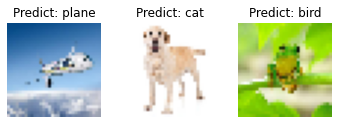

In [136]:
plt.figure(figsize=(10, 10))
index = 0
for _file in uploaded.keys():
    path = '/content/' + _file
    img = PIL.Image.open(path)
    img = pre_processing(img)

    image = torch.reshape(img, (1, 3, 32, 32))
    image = image.to(device)
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)

    img = img / 2 + 0.5
    npimg = np.array(img)
    trans_img = np.transpose(npimg, (1, 2, 0))
    index += 1

    plt.subplot(5, 5, index)
    plt.imshow(trans_img)
    plt.title("Predict: {}".format(classes[predicted[0]]))
    plt.axis("off")
plt.show()